In [1]:
import time
import random
import numpy as np
# import cupy as cp
import matplotlib.pyplot as plt
from collections import namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

random.seed(154012)
np.random.seed(154012)
torch.manual_seed(154012)

In [4]:
fc = 2.6 #2.6 GHz
bandwidth = 1e7 #10 MHz
temp = 40 + 273.15 # 40 celsius in kelvin
boltz = 1.381e-23
epsilon = 1e-7
row_bs = 4
col_bs = 4
mean_dist = 500
grid_width = mean_dist*(row_bs+1)
grid_height = mean_dist*(col_bs+1)
n_actions = 2

# if torch.cuda.is_available():
#   blackout_choices = cp.array([
#       [3*3600, 4*3600],
#       [6*3600, 4*3600],
#       [14*3600, 4*3600],
#       [19*3600, 4*3600],
#   ])
#   bs_loc = cp.mgrid[mean_dist: grid_width-mean_dist:mean_dist, mean_dist: grid_height-mean_dist:mean_dist]
#   bs_loc = bs_loc.reshape((2,-1)).T
#   bs_loc += mean_dist//10 - cp.random.randint(0, 2*mean_dist//10, bs_loc.shape)

#   bs_power = cp.array([40. for i in bs_loc])

#   print(bs_loc.shape)

#   bs_blackout = blackout_choices[cp.random.randint(0,3, (row_bs*col_bs))]


# else:
blackout_choices = np.array([
    [3*3600, 4*3600],
    [6*3600, 4*3600],
    [14*3600, 4*3600],
    [19*3600, 4*3600],
])

baseline_times = [0]
baseline_times.extend([i[0] for i in blackout_choices])
baseline_times.extend([i[0]+i[1]+1 for i in blackout_choices])
baseline_times.sort()

bs_loc = np.mgrid[mean_dist: grid_width:mean_dist, mean_dist: grid_height:mean_dist]
bs_loc = bs_loc.reshape((2,-1)).T
bs_loc += mean_dist//10 - np.random.randint(0, 2*mean_dist//10, bs_loc.shape)

bs_power = np.array([40. for i in bs_loc])

print(bs_loc.shape)

bs_blackout = blackout_choices[np.random.randint(0,3, (row_bs*col_bs))]

(16, 2)


In [3]:
# class Environment():
#     def __init__(self, bs_loc, bs_power, bs_blackouts, max_power, min_power, n_actions, grid_width, grid_height, n_nearest):
#         self.bs_loc = bs_loc
#         self.bs_power = bs_power
#         self.electricity = np.zeros_like(bs_power)
#         self.bs_blackout_start = bs_blackouts[:,0]
#         self.bs_blackout_end = np.sum(bs_blackouts, axis=-1)
#         self.apply_blackouts(0)
#         self.max_power = max_power # in watt
#         self.min_power = min_power
#         self.n_actions = n_actions
#         self.grid_width = grid_width
#         self.grid_height = grid_height
#         self.points = np.mgrid[0:grid_width, 0:grid_height]
#         self.points = np.stack(self.points, axis=-1)
#         self.powers = self.power_grid(self.bs_loc, self.bs_power, self.points)
#         self.bit_rate = self.bit_rate_from_grid()
#         self.reward = self.get_reward()
#         self.actions = self.watt_to_dbm(np.linspace(min_power, max_power, n_actions))
#         self.n_nearest = min(n_nearest, bs_power.shape[0])
#         self.n_bs = bs_power.shape[0]
        
        
    
#     def get_input_dim(self):
#         return self.n_nearest*4 # after adding has electricity attrib 3 will be changed to 4
    
#     def get_output_dim(self):
#         return self.n_actions
    
#     def apply_blackouts(self, time):
#         self.electricity = (time>=self.bs_blackout_start) & (time<=self.bs_blackout_end)
    
#     def make_action(self, bs_index, action):
#         state = self.get_state(bs_index) 
#         self.bs_power[bs_index] = self.actions[action]
#         self.powers = self.power_grid(self.bs_loc, self.bs_power, self.points)
#         self.bit_rate = self.bit_rate_from_grid()
#         next_state = self.get_state(bs_index)
#         reward = self.get_reward()
#         return state, action, next_state, reward
        
#     def watt_to_dbm(self, watt):
#         return 10*np.log10(1000*watt)

#     def dbm_to_watt(self, dbm):
#         return np.power(10, dbm/10)/1000

#     def path_loss(self, distance, frequency=fc):
#     #     return 36.7*np.log10(distance) + 47.7 + 26*np.log10(frequency)
#         return 35*np.log10(distance) + 35.7

#     def power_grid(self, bs_loc, bs_power, points):
#         powers = []
#         for loc, power in zip(bs_loc, bs_power):
#             distance = np.linalg.norm(loc - points+epsilon, axis=-1)
#             powers.append(power - self.path_loss(distance))
#         return np.stack(powers, axis=-1)

#     def get_bit_rate_sinr(self, signal, interference, bandwidth=bandwidth, temp=temp):
#         return bandwidth*np.log10(1+ (signal/(interference + temp*boltz*bandwidth)))
    
#     def bit_rate_from_grid(self):
#         max_power = self.dbm_to_watt(self.powers.max(axis=-1))
#         interference_power = self.dbm_to_watt(self.powers).sum(axis=-1) - max_power
#         return self.get_bit_rate_sinr(max_power, interference_power)

#     def bit_rate_cost_function(self, b_rate):
#         total_points = 1
#         for i in b_rate.shape:
#             total_points *= i

#         under_1mb = b_rate<(1024**2)*8
#         under_1mb = under_1mb.sum()
#         min_speed = b_rate.min()/(1024*1024*8) #1MB
#         return 10*under_1mb/total_points + 1/(min_speed+epsilon)

#     def get_reward(self):
#         constant = 10
#         br_cost = self.bit_rate_cost_function(self.bit_rate)
#         print(self.electricity.shape)
#         print(self.dbm_to_watt(self.bs_power))
#         elec_cost = np.inner(self.electricity, self.dbm_to_watt(self.bs_power))
#         return 10 - br_cost - elec_cost
    
#     def get_state(self, bs_index):
#         x,y = self.bs_loc[bs_index]
#         powers = self.powers[np.round(x),np.round(y),:].reshape(-1)
#         indecies = np.argsort(powers)[::-1][:self.n_nearest]
#         bs_index_posistion = np.where(indecies == bs_index)[0]
        
#         if bs_index_posistion.size > 0:
#             indecies = np.delete(indecies, bs_index_posistion)
#             indecies = indecies[:self.n_nearest]
#         else:
#             indecies = indecies[:self.n_nearest-1]
            
#         bs_power = powers[bs_index]
#         state = np.array([powers[bs_index], self.electricity[bs_index], 0, 0])
#         nearest_powers = powers[np.array(indecies)]
#         nearest_elec = self.electricity[np.array(indecies)]
#         diff =  self.bs_loc[np.array(indecies)] - self.bs_loc[bs_index]
#         nearest_distances = np.linalg.norm(diff, axis=-1)
#         nearest_angles = np.arctan2(diff[:,1].reshape(-1), diff[:,0].reshape(-1))
        
#         return np.hstack((state, np.stack([nearest_powers, nearest_elec,
#                                            nearest_distances, nearest_angles], axis=-1).reshape(-1)))
    
#     def plot_bit_rate(self):
#         plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
#     def plot_log_bit_rate(self):
#         plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
#     def plot_power_grid(self):
#         plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
#     def plot_log_power_grid(self):
#         plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)

In [44]:
class Environment():
    def __init__(self, bs_loc, bs_power, bs_blackouts, max_power, min_power, n_actions, grid_width, grid_height, n_nearest):
        self.bs_loc = bs_loc
        self.bs_power = bs_power
        self.electricity = np.zeros_like(bs_power) # 0 have electricity, 1 blackout
        self.bs_blackout_start = bs_blackouts[:,0]
        self.bs_blackout_end = np.sum(bs_blackouts, axis=-1)
        self.apply_blackouts(0)
        self.max_power = max_power # in watt
        self.min_power = min_power
        self.n_actions = n_actions
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.reward, _ = self.get_reward()
        self.actions = self.watt_to_dbm(np.linspace(min_power, max_power, n_actions))
        self.n_nearest = min(n_nearest, bs_power.shape[0])
        self.n_bs = bs_power.shape[0]
        self.episode = 0
        
    def baseline_action(self, bs_index):
        if self.electricity[bs_index]:
            self.set_action(bs_index, 0)
        else:
            self.set_action(bs_index, self.n_actions-1)

    def apply_baseline(self):
        for bs in range(self.bs_power.shape[0]):
            self.baseline_action(bs)

    def get_input_dim(self):
        return self.n_nearest*4 # after adding has electricity attrib 3 will be changed to 4
    
    def get_output_dim(self):
        return self.n_actions
    
    def apply_blackouts(self, time):
        self.episode = time
        self.electricity = (time>=self.bs_blackout_start) & (time<=self.bs_blackout_end)

    def set_action(self, bs_index, action):
        self.bs_power[bs_index] = self.actions[action]
    
    def make_action(self, bs_index, action):
        state = self.get_state(bs_index)
        self.set_action(bs_index, action)
        # print(action, "-", self.bs_power)
        # self.powers = self.power_grid(self.bs_loc, self.bs_power, self.points)
        # self.bit_rate = self.bit_rate_from_grid()
        next_state = self.get_state(bs_index) 
        kpi, reward = self.get_reward(bs_index)
        return state, action, next_state, reward, kpi
        
    def watt_to_dbm(self, watt):
        return 10*np.log10(1000*watt)

    def dbm_to_watt(self, dbm):
        return np.power(10, dbm/10)/1000

    def path_loss(self, distance, frequency=fc):
    #     return 36.7*np.log10(distance) + 47.7 + 26*np.log10(frequency)
        return 35*np.log10(distance+1) + 35.7

    def power_grid(self, bs_loc, bs_power, points):
        powers = []
        for loc, power in zip(bs_loc, bs_power):
            distance = np.linalg.norm(loc - points+epsilon, axis=-1)
            powers.append(power - self.path_loss(distance))
        return np.stack(powers, axis=-1)

    def get_bit_rate_sinr(self, signal, interference, bandwidth=bandwidth, temp=temp):
        return bandwidth*np.log10(1+ (signal/(interference + temp*boltz*bandwidth)))
    
    def bit_rate_from_grid(self, powers):
        max_power = self.dbm_to_watt(powers.max(axis=-1))
        interference_power = self.dbm_to_watt(powers).sum(axis=-1) - max_power
        return self.get_bit_rate_sinr(max_power, interference_power)

    def bit_rate_cost_function(self, b_rate):
        # total_points = self.grid_height * self.grid_width
        total_points = b_rate.shape[0]*b_rate.shape[1]

        under_1mb = b_rate<(1024**2)*8
        under_1mb = under_1mb.sum()
        min_speed = b_rate.min()/(1024*1024*8) #1MB
        max_speed = b_rate.max()/(1024*1024*8) #1MB
        return 10*under_1mb/total_points , min_speed, max_speed

    def get_reward(self, bs_index=None):
        constant = 10
        br_cost = 0
        max_cost = 0
        min_cost = 10000 # just arbitrary large number

        # number of points propotional to the width height
        # for i in range(0, self.grid_width, 1000):
        #     for j in range(0, self.grid_height, 1000):
        #         points = np.mgrid[i:min(i+1000, grid_width), j:min(j+1000, grid_height)]
        #         points = np.stack(points, axis=-1)
        #         power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        #         bit_rate = self.bit_rate_from_grid(power_grid)
        #         percentage, min_speed_cost, max_speed = self.bit_rate_cost_function(bit_rate)
        #         br_cost += percentage
        #         min_cost = min(min_cost, min_speed_cost)
        #         max_cost = max(max_cost, max_speed)


        # fixed number of point despite the width height
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_width, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        percentage, min_speed_cost, max_speed = self.bit_rate_cost_function(bit_rate)
        br_cost += percentage
        min_cost = min(min_cost, min_speed_cost)
        max_cost = max(max_cost, max_speed)

        # print(self.electricity.shape)
        # print(self.dbm_to_watt(self.bs_power))
        disparity = (max_cost - min_cost + epsilon)/ (max_cost + epsilon*epsilon) * 10
        elec_cost = np.inner(self.electricity, self.dbm_to_watt(self.bs_power))
        r = constant - br_cost + min_cost - disparity
        elec_loc_cost = elec_cost
        if (bs_index != None):
            elec_loc_cost = self.electricity[bs_index]*self.dbm_to_watt(self.bs_power[bs_index])
        return r-elec_cost, r-elec_loc_cost
    
    def get_state(self, bs_index):
        # get the base station location
        loc = self.bs_loc[bs_index]

        # get the recieved powers from each base station to the current base station
        powers = self.power_grid(self.bs_loc, self.bs_power, loc)
        # print("dbm")
        # print(powers)
        powers = self.dbm_to_watt(powers)
        # print("watt")
        # print(powers)

        # choose the base stations that give the most power to this location
        indecies = np.argsort(powers)[::-1][:self.n_nearest]

        # check if this base station is one of the base stations that gives the max power
        bs_index_posistion = np.where(indecies == bs_index)[0]
        

        # if the base station is one of them we remove it, that cause it is added later to the state
        # we do not we this value to be duplicated in the state
        if bs_index_posistion.size > 0:
            indecies = np.delete(indecies, bs_index_posistion)
            indecies = indecies[:self.n_nearest]
        else:
            indecies = indecies[:self.n_nearest-1]
            
        # get the power produce by the base station
        bs_power = powers[bs_index]
        self_power_norm = 1e3
        other_power_norm = 2e12 # mean dist 500

        # init state: rows represent base station 
        # in each row: recieved power, does it have electricity, distance from here, the angle
        state = np.array([bs_power*self_power_norm, 1 - self.electricity[bs_index], 0, 0])
        nearest_powers = other_power_norm*powers[np.array(indecies)]
        nearest_elec = 1 - self.electricity[np.array(indecies)]
        diff =  self.bs_loc[np.array(indecies)] - self.bs_loc[bs_index]
        nearest_distances = np.linalg.norm(diff, axis=-1)/ mean_dist
        nearest_angles = np.arctan2(diff[:,1].reshape(-1), diff[:,0].reshape(-1)) + np.pi
        
        state = np.hstack((state, np.stack([nearest_powers, nearest_elec,
                                           nearest_distances, nearest_angles], axis=-1).reshape(-1)))

        # print(state)
        return state
    
    def plot_bit_rate(self):
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        plt.contourf(points[:,:,0], points[:,:,1], bit_rate, 100, cmap = plt.cm.jet)
        
    def plot_log_bit_rate(self):
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        plt.contourf(points[:,:,0], points[:,:,1], np.log(bit_rate + epsilon), 100, cmap = plt.cm.jet)

    def save_bit_rate_plot(self, index=None):
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        # plt.contourf(points[:,:,0], points[:,:,1], bit_rate, 100, cmap = plt.cm.jet)
        # if not index:
        #     plt.savefig('bitrate.png')
        # else:
        #     name = "bitrate_{:06d}.png".format(index)
        #     plt.savefig(name)
        if index == None:
            plt.imsave('log_bitrate.png', np.log(bit_rate + epsilon), cmap = plt.cm.jet)
            # plt.savefig('log_bitrate.png')
        else:
            name = "log_bitrate_{:06d}.png".format(index)
            plt.imsave(name, np.log(bit_rate + epsilon), cmap = plt.cm.jet)
            # plt.savefig(name)
        
    def plot_watt_power_grid(self, index):
        if index < 0 or index >= self.n_bs:
            print("Invalid index")
            return
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        plt.contourf(points[:,:,0], points[:,:,1], self.dbm_to_watt(power_grid[:,:,index]), 100, cmap = plt.cm.jet)
        
    def plot_dbm_power_grid(self, index):
        if index < 0 or index >= self.n_bs:
            print("Invalid index")
            return
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        plt.contourf(points[:,:,0], points[:,:,1], power_grid[:,:,index], 100, cmap = plt.cm.jet)

In [240]:
class EnvironmentCluster():
    def __init__(self, bs_loc, bs_power, bs_blackouts, max_power, min_power, n_actions, grid_width, grid_height):
        self.bs_loc = bs_loc # locations of the base stations
        self.bs_power = bs_power # current power values of the base stations
        self.electricity = np.zeros_like(bs_power) # current electricity state 0 have electricity, 1 blackout
        self.bs_blackout_start = bs_blackouts[:,0] # times which blackout starts for each base station
        self.bs_blackout_end = np.sum(bs_blackouts, axis=-1) # times which blackout ends for each base station
        self.apply_blackouts(0)
        self.max_power = max_power # in watt
        self.min_power = min_power
        self.n_actions = n_actions
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.reward, _ = self.get_reward()
        self.actions = self.watt_to_dbm(np.linspace(min_power, max_power, n_actions))
        self.n_bs = bs_power.shape[0]
        self.episode = 0
        
    def baseline_action(self, bs_index):
        if self.electricity[bs_index]:
            self.set_action(bs_index, 0)
        else:
            self.set_action(bs_index, self.n_actions-1)

    def bulk_actions(self, actions):
        actions = np.round_(actions)
        # actions = actions.astype(int)
        self.bs_power = self.actions[actions]

    def apply_baseline(self):
        self.bulk_actions((1 - self.electricity)*(self.n_actions-1))

    def get_input_dim(self):
        return self.n_bs
    
    def get_output_dim(self):
        return self.n_bs
    
    def apply_blackouts(self, time):
        self.episode = time
        self.electricity = (time>=self.bs_blackout_start) & (time<=self.bs_blackout_end)

    def set_action(self, bs_index, action):
        self.bs_power[bs_index] = self.actions[action]
    
    def make_action(self, actions):
        state = self.get_state()
        self.bulk_actions(actions)
        next_state = self.get_state() 
        kpi, reward = self.get_reward()
        return state, action, next_state, reward, kpi
        
    def watt_to_dbm(self, watt):
        return 10*np.log10(1000*watt)

    def dbm_to_watt(self, dbm):
        return np.power(10, dbm/10)/1000

    def path_loss(self, distance):
        return 35*np.log10(distance+1) + 35.7

    def power_grid(self, bs_loc, bs_power, points):
        powers = []
        for loc, power in zip(bs_loc, bs_power):
            distance = np.linalg.norm(loc - points+epsilon, axis=-1)
            powers.append(power - self.path_loss(distance))
        return np.stack(powers, axis=-1)

    def get_bit_rate_sinr(self, signal, interference, bandwidth=bandwidth, temp=temp):
        return bandwidth*np.log10(1+ (signal/(interference + temp*boltz*bandwidth)))
    
    def bit_rate_from_grid(self, powers):
        max_power = self.dbm_to_watt(powers.max(axis=-1))
        interference_power = self.dbm_to_watt(powers).sum(axis=-1) - max_power
        return self.get_bit_rate_sinr(max_power, interference_power)

    def bit_rate_cost_function(self, b_rate):
        # total_points = self.grid_height * self.grid_width
        total_points = b_rate.shape[0]*b_rate.shape[1]

        under_1mb = b_rate<(1024**2)*8
        under_1mb = under_1mb.sum()
        min_speed = b_rate.min()/(1024*1024*8) #1MB
        max_speed = b_rate.max()/(1024*1024*8) #1MB
        return 10*under_1mb/total_points , min_speed, max_speed

    def get_reward(self):
        constant = 20
        br_cost = 0
        max_cost = 0
        min_cost = 10000 # just arbitrary large number


        # fixed number of point despite the width height
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_width, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        percentage, min_speed_cost, max_speed = self.bit_rate_cost_function(bit_rate)
        br_cost += percentage
        min_cost = min(min_cost, min_speed_cost)
        max_cost = max(max_cost, max_speed)

        # print(self.electricity.shape)
        # print(self.dbm_to_watt(self.bs_power))
        disparity = (max_cost - min_cost)/ (max_cost + 0.01) * 10
        elec_cost = np.inner(self.electricity, self.dbm_to_watt(self.bs_power))
        r = constant - br_cost + min_cost - disparity
        elec_loc_cost = elec_cost
        
        return r-elec_cost, r-elec_loc_cost
    
    def get_state(self):
        return self.electricity
    
    def plot_bit_rate(self):
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        plt.contourf(points[:,:,0], points[:,:,1], bit_rate, 100, cmap = plt.cm.jet)
        
    def plot_log_bit_rate(self):
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        plt.contourf(points[:,:,0], points[:,:,1], np.log(bit_rate + epsilon), 100, cmap = plt.cm.jet)

    def save_bit_rate_plot(self, index=None):
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        # plt.contourf(points[:,:,0], points[:,:,1], bit_rate, 100, cmap = plt.cm.jet)
        # if not index:
        #     plt.savefig('bitrate.png')
        # else:
        #     name = "bitrate_{:06d}.png".format(index)
        #     plt.savefig(name)
        if index == None:
            plt.imsave('log_bitrate.png', np.log(bit_rate + epsilon), cmap = plt.cm.jet)
            # plt.savefig('log_bitrate.png')
        else:
            name = "log_bitrate_{:06d}.png".format(index)
            plt.imsave(name, np.log(bit_rate + epsilon), cmap = plt.cm.jet)
            # plt.savefig(name)
        
    def plot_watt_power_grid(self, index):
        if index < 0 or index >= self.n_bs:
            print("Invalid index")
            return
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        plt.contourf(points[:,:,0], points[:,:,1], self.dbm_to_watt(power_grid[:,:,index]), 100, cmap = plt.cm.jet)
        
    def plot_dbm_power_grid(self, index):
        if index < 0 or index >= self.n_bs:
            print("Invalid index")
            return
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        plt.contourf(points[:,:,0], points[:,:,1], power_grid[:,:,index], 100, cmap = plt.cm.jet)

In [241]:
class DQN(nn.Module): # ready
    def __init__(self, n_inputs, n_actions):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(in_features=n_inputs, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=n_actions)

    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = F.relu(self.fc3(t))
        t = F.sigmoid(self.out(t))
        return t

In [242]:
Experience = namedtuple(
    "Experience", ("state", "action", "next_state", "reward")) # ready

In [243]:
class ReplayMemory(): # ready
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [244]:
class EpsilonGreedyStrategy(): # ready
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * np.exp(-1. * current_step * self.decay)

In [245]:
class Agent():
    def __init__(self, strategy, num_actions):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        t = random.random()
        
        # print(rate, t)
        if rate > t:
        #     action = random.randrange(self.num_actions) # for normal environment
            # action = random.randrange(self.num_actions+1) #when having 2 actions  for 1 bs or more
            # return torch.tensor([[action]])
            actions = np.random.randint(0, 2, (row_bs*col_bs)).astype(int)
            return torch.tensor([actions])
        else:
            with torch.no_grad():
                # return policy_net(state).argmax(dim=1) #when having multiple actions for 1 bs
                # return torch.round_(policy_net(state)).type(torch.IntTensor) #when having 2 actions  for 1 bs or more
                return torch.round(policy_net(state)).type(torch.IntTensor) #when having multiple bs

In [246]:
# class QValues():
#     @staticmethod
#     def get_current(policy_net, states, actions):
#         return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

#     @staticmethod
#     def get_next(target_net, next_states):
#         values = target_net(next_states).max(dim=1)[0].detach()
#         return values

class QValues():
    @staticmethod
    def get_current(policy_net, states, actions):
        dims = policy_net(states)
        # print(dims.shape)
        # print(dims.gather().shape)
        # print(actions.shape)
        # return dims.gather(dim=1, index=actions.unsqueeze(-1))
        return dims

    @staticmethod
    def get_next(target_net, next_states):
        # values = target_net(next_states).max(dim=1)[0].detach()
        values = target_net(next_states)
        return values

In [247]:
def get_moving_avg(values, period=25):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(
            dim=1).flatten(start_dim=0)
    else:
        moving_avg = torch.zeros_like(values)
    return moving_avg.numpy()

In [248]:
def plot(values, moving_avg_period=25):
    plt.figure(2)
    plt.clf()
    plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(values)

    moving_avg = get_moving_avg(values, moving_avg_period)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period,
          "episode moving avg:", moving_avg[-1])
#     if is_ipython:
#         display.clear_output(wait=True)

In [249]:
def extract_tensors(exps):
    batch = Experience(*zip(*exps))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.next_state)
    t4 = torch.cat(batch.reward)

    return (t1, t2, t3, t4)

In [257]:
batch_size = 64
gamma = 0.9
eps_start = 1
eps_end = 0.01
eps_decay = 0.01
target_update = 1
memory_size = 100_000
lr = 0.001
num_episodes = 24*3600
# print(bs_power.shape)
# env = Environment(bs_loc, bs_power, bs_blackout,10, 0, n_actions, grid_width, grid_height, 4)
env = EnvironmentCluster(bs_loc, bs_power, bs_blackout,10, 0, n_actions, grid_width, grid_height)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
# agent = Agent(strategy, env.get_output_dim()-1) # 2 actions 1 bs
agent = Agent(strategy, env.get_output_dim()) #any condition not the above
memory = ReplayMemory(memory_size)

<ipython-input-240-28085a90cb48>:54: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(1000*watt)


In [258]:
env.apply_blackouts(0)
for i in range(16):
    env.set_action(i, 1)

print(env.get_reward())
print(env.get_state())

(3.392780042870866, 3.392780042870866)
[False False False False False False False False False False False False
 False False False False]


In [231]:
print(len(baseline_times))
rewards_history = []
for i in baseline_times:
    print(i)
    env.apply_blackouts(i)
    env.apply_baseline()
    r, _ = env.get_reward()
    rewards_history.append([i, r])

print(*rewards_history)

9
0
10800
21600
25201


KeyboardInterrupt: 

In [259]:
# policy_net = DQN(env.get_input_dim(), env.get_output_dim()-1) # 2 actions 1 bs
# target_net = DQN(env.get_input_dim(), env.get_output_dim()-1) # 2 actions 1 bs
policy_net = DQN(env.get_input_dim(), env.get_output_dim()) # anything else
target_net = DQN(env.get_input_dim(), env.get_output_dim()) # anything else
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
print(env.get_input_dim())

16


In [260]:
# env = Environment(bs_loc, bs_power, bs_blackout,10, 0, n_actions, grid_width, grid_height, 4)
env = EnvironmentCluster(bs_loc, bs_power, bs_blackout,10, 0, n_actions, grid_width, grid_height)
num_episodes = 24*3600
step = 60
print(env.reward)

3.392780042870866


<ipython-input-240-28085a90cb48>:54: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(1000*watt)


In [261]:
# target_update = 1
target_update = 10

In [262]:
# kpis = [env.reward]
# for episode in range(0, num_episodes+1, step):
#     ep_timer = time.time()
#     print("\n\nEPISODE_{:03d}:".format(episode+1))
    
#     env.apply_blackouts(episode+1)
    
#     for i in range(env.n_bs):
#         timer = time.time()
#         state = torch.tensor(env.get_state(i), dtype=torch.float).unsqueeze(0)
#         # print(time.time() - timer)

#         action = agent.select_action(state, policy_net)
#         # print(action)
#         # print(time.time() - timer)
#         _, action, next_state, reward, kpi = env.make_action(i, action)
#         # print(time.time() - timer)
        
#         kpis.append(kpi)

#         reward = torch.tensor([reward], dtype=torch.float)
#         next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)
#         memory.push(Experience(state, action, next_state, reward))
#         state = next_state

#         if memory.can_provide_sample(batch_size):
#             exps = memory.sample(batch_size)
#             states, actions, next_states, rewards = extract_tensors(exps)
#             current_q_values = QValues.get_current(policy_net, states, actions)
#             next_q_values = QValues.get_next(target_net, next_states)
#             target_q_values = (next_q_values * gamma) + rewards

#             optimizer.zero_grad()
#             loss = F.smooth_l1_loss(
#                 current_q_values, target_q_values.unsqueeze(1))
#             loss.backward()
#             optimizer.step()

#         print("\tBS_{:02d} DONE IN {} SECONDS, reward {}, action {}, kpi {}".format(i+1, time.time() - timer, reward[0], action[0], kpi))

#     if episode % target_update == 0:
#         target_net.load_state_dict(policy_net.state_dict())

#     timer2 = time.time()
#     env.save_bit_rate_plot(episode+1)
#     print("EPISODE_{:03d} DONE IN {} SECONDS, WITH KPI {}, PLOTTING TOOK {}".format(episode+1, time.time() - ep_timer, kpi,time.time() - timer2))

In [263]:
kpis = [env.reward]
for episode in range(0, num_episodes+1, step):
    ep_timer = time.time()
    print("EPISODE_{:03d}:".format(episode+1))
    
    env.apply_blackouts(episode+1)

    state = torch.tensor(env.get_state(), dtype=torch.float).unsqueeze(0)
    # print(state.shape)
    # print(time.time() - timer)

    action = agent.select_action(state, policy_net)
    # print(time.time() - timer)
    print(action)
    _, action, next_state, reward, kpi = env.make_action(action[0])
    # print(time.time() - timer)
    
    kpis.append(kpi)

    reward = torch.tensor([reward], dtype=torch.float)
    next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)
    memory.push(Experience(state, action, next_state, reward))
    state = next_state

    if memory.can_provide_sample(batch_size):
        exps = memory.sample(batch_size)
        states, actions, next_states, rewards = extract_tensors(exps)
        current_q_values = QValues.get_current(policy_net, states, actions)
        # print(current_q_values.shape)
        next_q_values = QValues.get_next(target_net, next_states)
        # print(next_q_values.shape)
        # print(rewards.repeat((16,1)).T[0])
        target_q_values = (next_q_values * gamma) + rewards.repeat((16,1)).T

        optimizer.zero_grad()
        loss = F.smooth_l1_loss(
            current_q_values, target_q_values)
        loss.backward()
        optimizer.step()


    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    timer2 = time.time()
    env.save_bit_rate_plot(episode+1)
    print("EPISODE_{:03d} DONE IN {} SECONDS, reward {}".format(episode//step + 1, time.time() - ep_timer, reward[0]))

EPISODE_001:
tensor([[1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]])
EPISODE_001 DONE IN 4.003678560256958 SECONDS, reward 3.1619160175323486
EPISODE_061:
tensor([[0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]], dtype=torch.int32)


/home/ahmed/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPISODE_002 DONE IN 4.057104587554932 SECONDS, reward 3.8795359134674072
EPISODE_121:
tensor([[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1]])
EPISODE_003 DONE IN 4.234703779220581 SECONDS, reward 3.730008363723755
EPISODE_181:
tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]])
EPISODE_004 DONE IN 3.849219799041748 SECONDS, reward 3.6292293071746826
EPISODE_241:
tensor([[0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]], dtype=torch.int32)
EPISODE_005 DONE IN 4.081794023513794 SECONDS, reward 3.8795359134674072
EPISODE_301:
tensor([[1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]])
EPISODE_006 DONE IN 4.153817653656006 SECONDS, reward 2.9879627227783203
EPISODE_361:
tensor([[1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]])
EPISODE_007 DONE IN 4.023003816604614 SECONDS, reward 3.029538869857788
EPISODE_421:
tensor([[0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]])
EPISODE_008 DONE IN 4.125831127166748 SECONDS, reward 3.1514317989349365
EPISODE_481:
tensor([[1, 1, 1, 0, 1, 1, 

KeyboardInterrupt: 

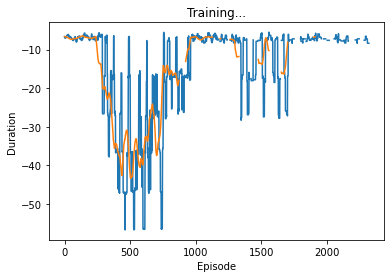

Episode 2321 
 50 episode moving avg: nan


In [19]:
plot(kpis, 50)

In [ ]:
env.get_reward()

In [267]:
class Critic(nn.Module):
    def __init__(self, input_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, 32)
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32, 32)
        self.out = nn.Linear(32, output_size)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.out(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, 32)
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32, 32)
        self.out = nn.Linear(32, output_size)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = torch.sigmoid(self.out(x))

        return x

In [268]:
# Taken from https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py

# class OUNoise(object):
#     def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
#         self.mu           = mu
#         self.theta        = theta
#         self.sigma        = max_sigma
#         self.max_sigma    = max_sigma
#         self.min_sigma    = min_sigma
#         self.decay_period = decay_period
#         self.action_dim   = action_space.shape[0]
#         self.low          = action_space.low
#         self.high         = action_space.high
#         self.reset()
        
#     def reset(self):
#         self.state = np.ones(self.action_dim) * self.mu
        
#     def evolve_state(self):
#         x  = self.state
#         dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
#         self.state = x + dx
#         return self.state
    
#     def get_action(self, action, t=0): 
#         ou_state = self.evolve_state()
#         self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
#         return np.clip(action + ou_state, self.low, self.high)

# THIS IS USED FOR CONTINUOUS ACTION SPACE AS NOISE FOR EXPLORATION VS EXPLOITATION

In [269]:
# env2 = Environment(bs_loc, bs_power, bs_blackout,10, 0, n_actions, grid_width, grid_height, 4)
env2 = EnvironmentCluster(bs_loc, bs_power, bs_blackout,10, 0, n_actions, grid_width, grid_height)
strategy2 = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent2 = Agent(strategy2, env.get_output_dim())
memory2 = ReplayMemory(memory_size)

actor = Actor(env2.get_input_dim(), env2.get_output_dim())
actor_target = Actor(env2.get_input_dim(), env2.get_output_dim())
critic = Critic(env2.get_input_dim() + env2.get_output_dim(), env2.get_output_dim())
critic_target = Critic(env2.get_input_dim() + env2.get_output_dim(), env2.get_output_dim())

for target_param, param in zip(actor_target.parameters(), actor.parameters()):
    target_param.data.copy_(param.data)
for target_param, param in zip(critic_target.parameters(), critic.parameters()):
    target_param.data.copy_(param.data)


critic_criterion  = nn.MSELoss()
actor_optimizer  = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

tau=1e-2

<ipython-input-240-28085a90cb48>:54: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(1000*watt)


In [270]:
# kpis2 = []
# for episode in range(0, num_episodes+1, step):
#     ep_timer = time.time()
#     print("\n\nEPISODE_{:03d}:".format(episode+1))
    
#     env2.apply_blackouts(episode+1)
    
#     for i in range(env2.n_bs):
#         timer = time.time()
#         state = torch.tensor(env2.get_state(i), dtype=torch.float).unsqueeze(0)

#         action = agent2.select_action(state, actor) 
#         _, action, next_state, reward, kpi = env2.make_action(i, action)
        
#         kpis2.append(kpi) #

#         reward = torch.tensor([reward], dtype=torch.float)
#         next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)
#         memory2.push(Experience(state, action, next_state, reward))
#         state = next_state

#         if memory2.can_provide_sample(batch_size):
#             exps = memory2.sample(batch_size)
#             states, actions, next_states, rewards = extract_tensors(exps)

#             actions_onehot = actions.numpy()
#             actions_onehot = (np.arange(env2.get_output_dim()) == actions_onehot[:,None]).astype(np.float32)
#             actions_onehot = torch.from_numpy(actions_onehot)
            
#             Qvals = critic.forward(states, actions_onehot)
#             next_actions = actor_target.forward(next_states)
#             next_Q = critic_target.forward(next_states, next_actions.detach())
#             Qprime = rewards.unsqueeze(1) + gamma * next_Q
#             critic_loss = critic_criterion(Qvals, Qprime)

#             # Actor loss
#             policy_loss = -critic.forward(states, actor.forward(states)).mean()
            
#             # update networks
#             actor_optimizer.zero_grad()
#             policy_loss.backward()
#             actor_optimizer.step()

#             critic_optimizer.zero_grad()
#             critic_loss.backward() 
#             critic_optimizer.step()

#         print("\tBS_{:02d} DONE IN {} SECONDS, reward {}, action {}, kpi {}".format(i+1, time.time() - timer, reward[0], action[0], kpi))

#     for target_param, param in zip(actor_target.parameters(), actor.parameters()):
#         target_param.data.copy_(param.data * tau + target_param.data * (1.0 - tau))

#     for target_param, param in zip(critic_target.parameters(), critic.parameters()):
#         target_param.data.copy_(param.data * tau + target_param.data * (1.0 - tau))

#     print("\tBS_{:02d} DONE IN {} SECONDS, reward {}".format(i+1, time.time() - ep_timer, kpi))



EPISODE_001:


TypeError: get_state() takes 1 positional argument but 2 were given

In [272]:
kpis2 = []
for episode in range(0, num_episodes+1, step):
    ep_timer = time.time()
    print("\n\nEPISODE_{:03d}:".format(episode+1))
    
    env2.apply_blackouts(episode+1)
    state = torch.tensor(env2.get_state(), dtype=torch.float)

    action = agent2.select_action(state, actor) 
    _, action, next_state, reward, kpi = env2.make_action(action)
    
    kpis2.append(kpi) 

    reward = torch.tensor([reward], dtype=torch.float)
    next_state = torch.tensor(next_state, dtype=torch.float)
    memory2.push(Experience(state, action, next_state, reward))
    state = next_state

    if memory2.can_provide_sample(batch_size):
        exps = memory2.sample(batch_size)
        states, actions, next_states, rewards = extract_tensors(exps)

        actions_onehot = actions.numpy()
        # actions_onehot = (np.arange(env2.get_output_dim()) == actions_onehot[:,None]).astype(np.float32)
        # actions_onehot = torch.from_numpy(actions_onehot)
        
        Qvals = critic.forward(states, actions_onehot)
        next_actions = actor_target.forward(next_states)
        next_Q = critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards.unsqueeze(1) + gamma * next_Q
        critic_loss = critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -critic.forward(states, actor.forward(states)).mean()
        
        # update networks
        actor_optimizer.zero_grad()
        policy_loss.backward()
        actor_optimizer.step()

        critic_optimizer.zero_grad()
        critic_loss.backward() 
        critic_optimizer.step()

    for target_param, param in zip(actor_target.parameters(), actor.parameters()):
        target_param.data.copy_(param.data * tau + target_param.data * (1.0 - tau))

    for target_param, param in zip(critic_target.parameters(), critic.parameters()):
        target_param.data.copy_(param.data * tau + target_param.data * (1.0 - tau))

    print("\tBS_{:02d} DONE IN {} SECONDS, reward {}".format(i+1, time.time() - ep_timer, kpi))



EPISODE_001:


ValueError: operands could not be broadcast together with shapes (16,) (1001,1001) 

In [23]:
a = np.array([0,0,0])
b = a + 1
print(np.column_stack((a,b)).ravel())

[0 1 0 1 0 1]
